In [1]:
library('tidymodels')
library('palmerpenguins')
library('vip')

theme_set(theme_gray(base_size = 16))

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.4     ✔ recipes      1.0.5
✔ dials        1.1.0     ✔ rsample      1.1.1
✔ dplyr        1.1.0     ✔ tibble       3.2.0
✔ ggplot2      3.4.1     ✔ tidyr        1.3.0
✔ infer        1.0.4     ✔ tune         1.0.1
✔ modeldata    1.1.0     ✔ workflows    1.1.3
✔ parsnip      1.0.4     ✔ workflowsets 1.0.0
✔ purrr        1.0.1     ✔ yardstick    1.1.0

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Learn how to get started at https://www.tidymodels.org/start/


Attaching package: ‘palmerpenguins’


The following object is masked from ‘package:modeldata’:

    penguins



Attaching package: ‘vip’


The following object is masked from ‘package:utils’:

    vi




In [2]:
penguins2 = penguins |>
    drop_na()

penguins2 |> head()

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
<fct>,<fct>,<dbl>,<dbl>,<int>,<int>,<fct>,<int>
Adelie,Torgersen,39.1,18.7,181,3750,male,2007
Adelie,Torgersen,39.5,17.4,186,3800,female,2007
Adelie,Torgersen,40.3,18.0,195,3250,female,2007
Adelie,Torgersen,36.7,19.3,193,3450,female,2007
Adelie,Torgersen,39.3,20.6,190,3650,male,2007
Adelie,Torgersen,38.9,17.8,181,3625,female,2007


## Use random forests to model `bill_length_mm`

In [3]:
mod = rand_forest() |> 
    set_engine('ranger', importance = 'impurity') |>
    set_mode('regression')

In [4]:
rec = recipe(bill_length_mm ~ ., data = penguins2) |>
    step_rm(year) |>
    step_dummy(sex, island, species) |>
    prep(retain = TRUE)

rec |> juice() |> head()

bill_depth_mm,flipper_length_mm,body_mass_g,bill_length_mm,sex_male,island_Dream,island_Torgersen,species_Chinstrap,species_Gentoo
<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18.7,181,3750,39.1,1,0,1,0,0
17.4,186,3800,39.5,0,0,1,0,0
18.0,195,3250,40.3,0,0,1,0,0
19.3,193,3450,36.7,0,0,1,0,0
20.6,190,3650,39.3,1,0,1,0,0
17.8,181,3625,38.9,0,0,1,0,0


In [5]:
wf = workflow() |> 
  add_recipe(rec) |> 
  add_model(mod)

wf_fit = wf |> fit(data = penguins2)

wf_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: rand_forest()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_rm()
• step_dummy()

── Model ───────────────────────────────────────────────────────────────────────
Ranger result

Call:
 ranger::ranger(x = maybe_data_frame(x), y = y, importance = ~"impurity",      num.threads = 1, verbose = FALSE, seed = sample.int(10^5,          1)) 

Type:                             Regression 
Number of trees:                  500 
Sample size:                      333 
Number of independent variables:  8 
Mtry:                             2 
Target node size:                 5 
Variable importance mode:         impurity 
Splitrule:                        variance 
OOB prediction error (MSE):       5.757764 
R squared (OOB):                  0.8074734 

In [7]:
outcomes = augment(wf_fit |> extract_fit_parsnip(), 
                   new_data = rec |> juice())

outcomes |> head()

bill_depth_mm,flipper_length_mm,body_mass_g,bill_length_mm,sex_male,island_Dream,island_Torgersen,species_Chinstrap,species_Gentoo,.pred
<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18.7,181,3750,39.1,1,0,1,0,0,39.23095
17.4,186,3800,39.5,0,0,1,0,0,37.93933
18.0,195,3250,40.3,0,0,1,0,0,38.80240
19.3,193,3450,36.7,0,0,1,0,0,37.83611
20.6,190,3650,39.3,1,0,1,0,0,39.04901
17.8,181,3625,38.9,0,0,1,0,0,38.30191


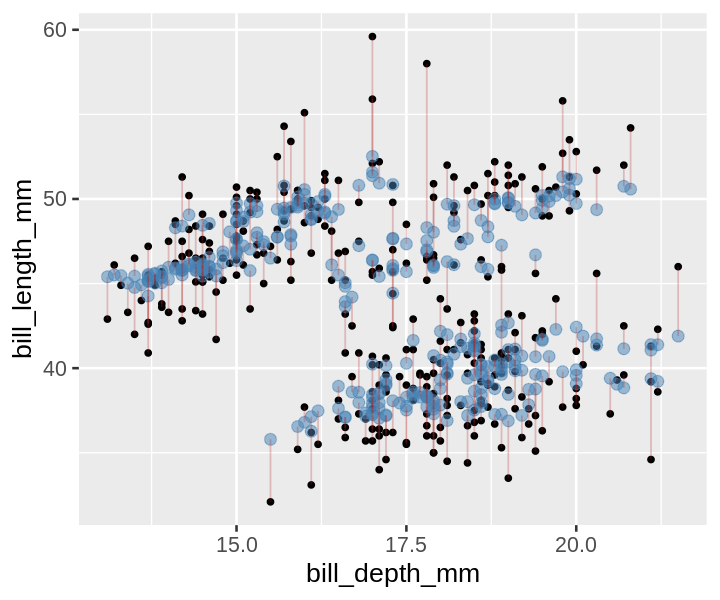

In [8]:
options(repr.plot.width = 6, repr.plot.height = 5)

ggplot(outcomes) +
    geom_point(aes(x = bill_depth_mm, y = bill_length_mm)) + 
    geom_point(aes(x = bill_depth_mm, y = .pred), color = 'steelblue', size = 3,
               alpha = 0.5) +
    geom_segment(aes(x = bill_depth_mm, xend = bill_depth_mm, y = .pred, yend = bill_length_mm), 
                 color = 'firebrick',
                 alpha = 0.25)

## Visualize feature importance

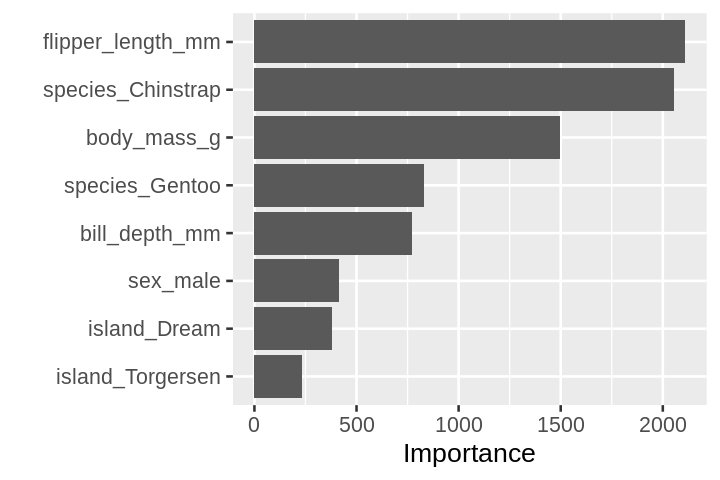

In [9]:
options(repr.plot.width = 6, repr.plot.height = 4)

wf_fit |> 
  extract_fit_parsnip() |> 
  vip()